<a href="https://colab.research.google.com/github/Miguel743/proyectosDatos/blob/main/comportamiento_cryto_guerra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo de proyecto
*    En el presente proyecto tratamos de responder a la siguiente pregunta: 
¿Qué mercado financiero se comporto "mejor" a partir del comienzo de la guerra entre Rusia y Ucrania?
Para responder al a misma utilizaremos los principales indicadores que caracterizan a las principales bolsas mundiales. Nos remitiremos aquellos indicadores que caracterizan el mercado accionario de cada pais. 
*    Es de vital importancia que el presente trabajo se basa en el trabajo desarrollado por el Ing. Juan Pablo Pisano denominado "Comparación de retorno y riesgos de activos, desde inicio de la guerra" (https://twitter.com/JohnGalt_is_www/status/1505218971821350915?s=20&t=LUiNcLMYvi0tyoJtLVmYew)

# Imports

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.4 MB 16.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Descargar Data

In [ ]:
tickers = {'BTC-USD':'Bitcoin','ETH-USD':'Ethereum','ADA-USD':'Cardano','DOGE-USD':'Dogecoin','SOL-USD':'Solana'}
ticks = list(set(tickers.keys()))
ticks.sort()
names = [tickers[x] for x in ticks]

inicio = "2022-02-20"
final = (datetime.strptime(inicio, '%Y-%m-%d') + timedelta(days=60)).isoformat()[:10]
data = yf.download(ticks, interval='5m', auto_adjust=True, start=inicio, end=final)['Close']
data = data.interpolate().dropna()
base_100 = data.divide(data.iloc[0]).mul(100)


vix = yf.download('^VIX', interval='5m', start=inicio, end=final)['Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
#print(tickers)
names

['Cardano', 'Bitcoin', 'Dogecoin', 'Ethereum', 'Solana']

# Calculos

In [ ]:
base_100.columns = names
T = (base_100.index[-1]-base_100.index[0]).days + (base_100.index[-1]-base_100.index[0]).seconds/(3600*24)

sigma = base_100.pct_change().std().mul((12*24*365)**0.5)
v = base_100.pct_change()
semidesvios = pd.DataFrame()
for col in v.columns:
    semidesvios[col] = np.where(v[col]>0, 0, v[col])
semidesvios = semidesvios.std().mul((12*24*365)**0.5)

yields = base_100.iloc[-1].add(-100)
rango = base_100.max()-base_100.min()
max_dd = (base_100/base_100.cummax()-1).min()
calmar = -1*yields/100/max_dd

area_izq, area_der, rachev = {}, {}, {}
for col in v.columns:
    area_izq[col] = (v[col].loc[v[col] < v[col].quantile(0.01)]).sum()
    area_der[col] = (v[col].loc[v[col] > v[col].quantile(0.99)]).sum()
    rachev[col] = -area_der[col] / area_izq[col]

ann_ret = yields/100*365/T
sharpe = ann_ret/sigma
sortino = ann_ret/semidesvios

# Gráfico

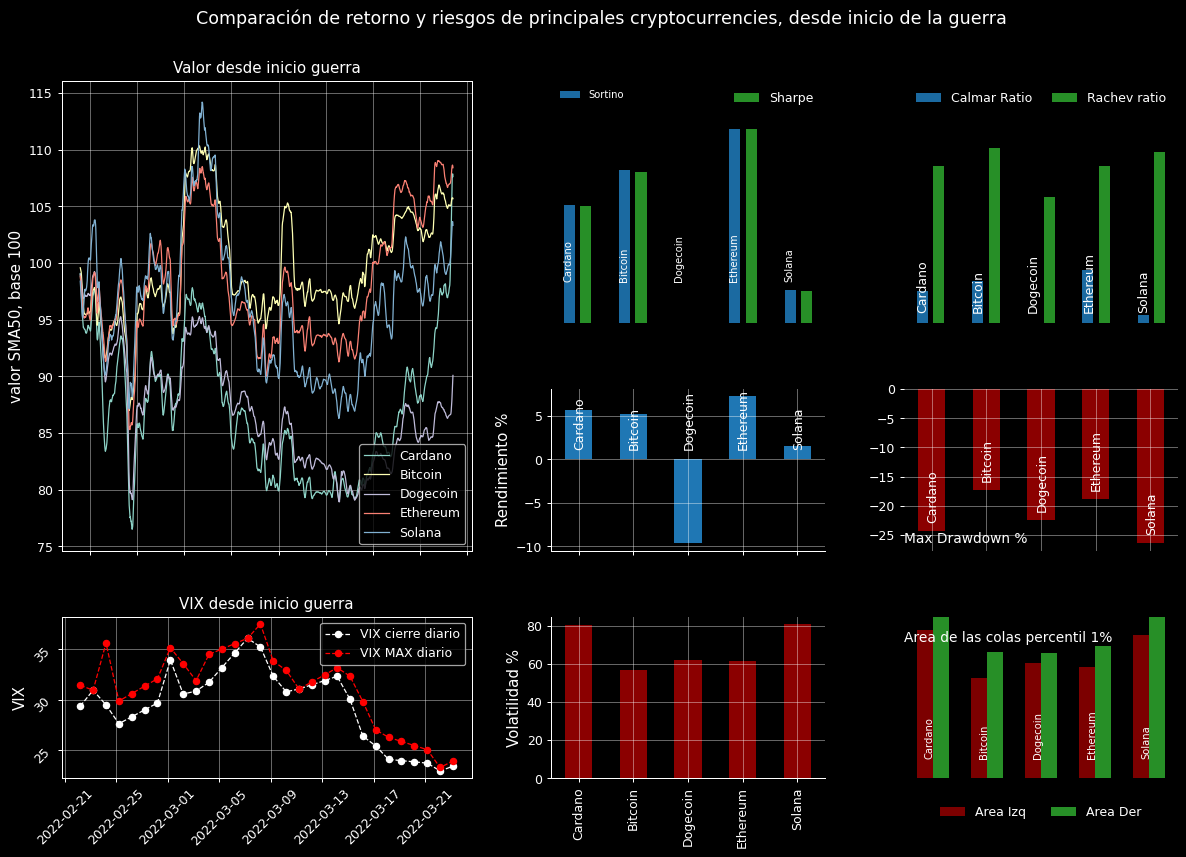

In [ ]:
# General
plt.style.use('dark_background') # dark_background
plt.rcParams['figure.dpi'] = 90
title = 'Comparación de retorno y riesgos de principales cryptocurrencies, desde inicio de la guerra'

# Grilla
fig = plt.figure(figsize=(16,10))
gs = GridSpec(nrows=3,ncols=3, figure=fig, height_ratios=[1.5,1,1], width_ratios=[1.5,1,1], 
              wspace=0.25, hspace=0.35,  top=.9, right=0.9)

ax_l = [fig.add_subplot(gs[:2,0]), fig.add_subplot(gs[2,0]),]
ax_m = [fig.add_subplot(gs[i,1]) for i in range(3)]
ax_r = [fig.add_subplot(gs[i,2]) for i in range(3)]
plt.suptitle(title, y=0.98, fontsize=14)


# Graficos Columna izquierda
ax_l[0].plot(base_100.rolling(50).mean(),lw=1)
ax_l[0].set_ylabel('valor SMA50, base 100', fontsize=12)
ax_l[0].grid(alpha=0.4)
ax_l[0].legend(base_100.columns, loc='lower right', fontsize= 10)
ax_l[0].set_title('Valor desde inicio guerra')
ax_l[0].tick_params(axis='x', labelbottom=False)

vix_cierre = vix.resample('D').last().interpolate()
vix_max = vix.resample('D').max().interpolate()
ax_l[1].plot(vix_cierre, lw=1, ls='--', markersize=5, marker='o', c='white', label='VIX cierre diario')
ax_l[1].plot(vix_max, lw=1, ls='--', markersize=5, marker='o', c='red', label='VIX MAX diario')
ax_l[1].grid(alpha=0.4)
ax_l[1].set_title('VIX desde inicio guerra')
ax_l[1].tick_params(labelrotation=45)
ax_l[1].set_ylabel('VIX', fontsize=12)
ax_l[1].legend()


# Graficos Columna del medio
# Sortino y Sharpe
x = np.arange(len(sharpe.index))
ax_m[0].bar(x, sortino, color='tab:blue', alpha=0.9, width=0.2, label='Sortino')
ax_m_sec = ax_m[0].twinx()
ax_m_sec.bar(x+0.3, sharpe, color='tab:green', alpha=0.9, width=0.2, label='Sharpe')
ax_m_sec.set_ylim(0, sharpe.max()*1.25)
ax_m_sec.legend(fontsize=10, frameon=False)


ax_m[0].grid(alpha=0.4)
ax_m[0].legend(loc='upper left', fontsize=8, frameon=False)
ax_m[0].set_ylim(0,sortino.max()*1.25)
for i, col in enumerate(v.columns):
    ax_m[0].annotate(col, xy=(i-0.1,0.5), color='white', rotation=90, fontsize=8)
ax_m[0].axis('off')
ax_m_sec.axis('off')

# Rendimiento
yields.plot(kind='bar', color='tab:blue', width=0.5, ax=ax_m[1])
ax_m[1].set_ylabel('Rendimiento %', fontsize=12)
ax_m[1].grid(alpha=0.4)
ax_m[1].tick_params(axis='x', labelbottom=False)
ax_m[1].spines['right'].set_visible(False)
ax_m[1].spines['top'].set_visible(False)

# Volatilidad
sigma.mul(100).plot(kind='bar', color='darkred', ax=ax_m[2])
ax_m[2].grid(alpha=0.4)
ax_m[2].set_ylabel('Volatilidad %', fontsize=12)
ax_m[2].spines['right'].set_visible(False)
ax_m[2].spines['top'].set_visible(False)


# Graficos Columna derecha
ax_r[0].bar(x, calmar, color='tab:blue', alpha=0.9, width=0.2, label='Calmar Ratio')
ax_r_sec = ax_r[0].twinx()
ax_r_sec.bar(x+0.3, rachev.values(), color='tab:green', alpha=0.9, width=0.2, label='Rachev ratio')
ax_r_sec.set_ylim(0.75,1.35)
ax_r_sec.legend(fontsize=10, frameon=False)

ax_r[0].grid(alpha=0.4)
ax_r[0].legend(loc='upper left', fontsize=10, frameon=False)
ax_r[0].set_ylim(0,1.75)
for i, col in enumerate(v.columns):
    ax_r[0].annotate(col, xy=(i-0.1,0.1), color='white', rotation=90)
    ax_r[1].annotate(col, xy=(i-0.1,max_dd[col]*100+2), color='white', rotation=90, fontsize=10)
    ax_m[1].annotate(col, xy=(i-0.1,1.5), color='white', rotation=90, fontsize=10)
ax_r[0].axis('off')
ax_r_sec.axis('off')

max_dd.mul(100).plot(kind='bar', color='darkred', width=0.5, ax=ax_r[1])
ax_r[1].tick_params(axis='x', labelbottom=False)
ax_r[1].spines['right'].set_visible(False)
ax_r[1].spines['bottom'].set_visible(False)
ax_r[1].spines['left'].set_visible(False)
ax_r[1].spines['top'].set_visible(False)
ax_r[1].tick_params(axis='x', bottom=False)
ax_r[1].grid(alpha=0.4)
ax_r[1].set_title('Max Drawdown %', fontsize=11, y=0, x=0, loc='left')

ax_r[2].bar(x, -np.array(list(area_izq.values())), color='darkred', alpha=0.9, width=0.3, label='Area Izq')
ax_r[2].bar(x+0.3, area_der.values(), color='tab:green', alpha=0.9, width=0.3, label='Area Der')
ax_r[2].axis('off')
ax_r[2].set_title('Area de las colas percentil 1%', fontsize=11, y=0.8, x=0, loc='left')
ax_r[2].grid(alpha=0.4)
ax_r[2].legend(loc='upper center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.1))
ax_r[2].set_ylim(0.2, 0.95)
ax_r[2].tick_params(axis='x', labelbottom=False)
for i, col in enumerate(v.columns):
    ax_r[2].annotate(col, xy=(i-0,0.3), color='white', rotation=90,fontsize=8)


plt.show()